<a href="https://colab.research.google.com/github/Tahahaha7/Travel_Time_Algiers/blob/main/Algiers_Road_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## $\text{Dependencies}$

In [1]:
%%capture
!apt install libspatialindex-dev
!pip install -Iv osmnx==0.16.0
!pip install -U googlemaps
!pip install rtree
!pip install momepy
!pip install osmapi

In [ ]:
!pip install pandas==1.2.4

In [1]:
import pandas as pd
pd.__version__

'1.2.4'

In [3]:
# Importing packages

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import operator
import osmnx as ox
import geopandas
import momepy

import googlemaps
from datetime import datetime
#gmaps = googlemaps.Client(key='key')

%matplotlib inline
ox.config(use_cache=True, log_console=True)
weight = 'length'

ox.__version__

'0.16.0'

## $\text{Road Network}$

In [ ]:
# Exrtact the entire road network of the city
%%time
road_network = ox.graph_from_place('Alger, Algeria', network_type='drive')
graph_nx = nx.relabel.convert_node_labels_to_integers(road_network)

CPU times: user 1min 15s, sys: 1.97 s, total: 1min 17s
Wall time: 1min 16s


In [ ]:
print(nx.info(graph_nx))

Name: 
Type: MultiDiGraph
Number of nodes: 42568
Number of edges: 104871
Average in degree:   2.4636
Average out degree:   2.4636


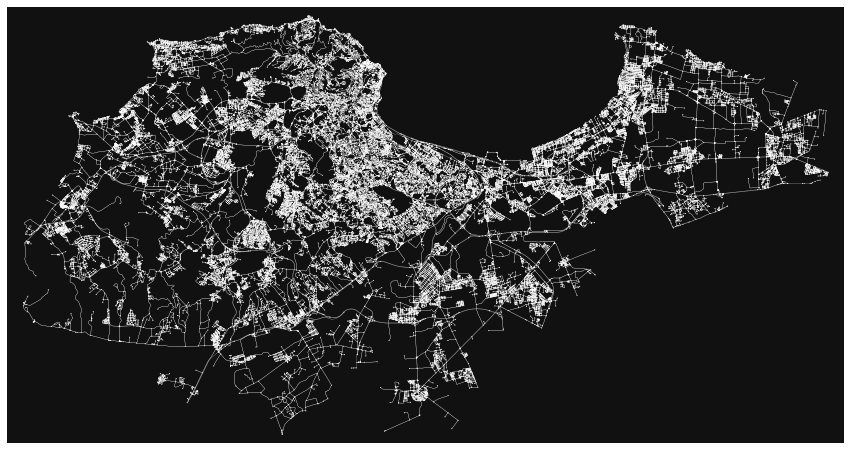

In [ ]:
fig, ax = ox.plot_graph(road_network, node_size=1, edge_color='w', edge_linewidth=0.2, figsize=(15, 12))

In [ ]:
node_data = pd.DataFrame.from_dict(dict(graph_nx.nodes(data=True)), orient='index')
node_data.head()

,y,x,osmid,ref,highway
0,36.741099,3.120854,26616005,NaN,NaN
1,36.726903,3.212662,26616060,NaN,NaN
2,36.732532,3.150730,26616092,S7,motorway_junction
3,36.748889,3.084669,26616224,RN 3,motorway_junction
4,36.749332,3.083872,26616249,NaN,NaN


In [ ]:
edge_data = nx.to_pandas_edgelist(graph_nx)
edge_data.head()

,source,target,access,oneway,bridge,width,geometry,service,length,highway,lanes,name,tunnel,area,ref,junction,maxspeed,osmid
0,0,32845,NaN,True,NaN,NaN,"LINESTRING (3.1208536 36.7410995, 3.1193613 36...",NaN,2243.451,motorway,3,Rocade Nord,NaN,NaN,RN 11;RN 5,NaN,80,"[404275988, 201013430]"
1,1,2510,NaN,True,NaN,NaN,"LINESTRING (3.2126618 36.7269033, 3.2112106 36...",NaN,259.522,motorway,3,Rocade Nord,NaN,NaN,RN 11,NaN,80,26222474
2,2,699,NaN,True,NaN,NaN,"LINESTRING (3.1507303 36.7325321, 3.1511528 36...",NaN,639.430,motorway_link,NaN,NaN,NaN,NaN,NaN,NaN,"[30, 60]","[26222779, 26222334]"
3,2,25183,NaN,True,NaN,NaN,"LINESTRING (3.1507303 36.7325321, 3.1514387 36...",NaN,341.083,motorway,3,Rocade Nord,NaN,NaN,RN 11,NaN,80,224436597
4,3,144,NaN,True,NaN,NaN,"LINESTRING (3.0846688 36.7488895, 3.0857232 36...",NaN,326.667,trunk,2,Avenue de l'ALN,NaN,NaN,RN 5,NaN,60,263701581


In [ ]:
coor_dict = dict(zip(node_data.index, zip(node_data.y, node_data.x)))
edge_data.insert(1, 'source_coor', [coor_dict.get(i) for i in edge_data.source])
edge_data.insert(3, 'target_coor', [coor_dict.get(i) for i in edge_data.target])

In [ ]:
edge_data.head()

,source,source_coor,target,target_coor,access,oneway,bridge,width,geometry,service,length,highway,lanes,name,tunnel,area,ref,junction,maxspeed,osmid
0,0,"(36.7410995, 3.1208536)",32845,"(36.7464021, 3.0965701)",NaN,True,NaN,NaN,"LINESTRING (3.1208536 36.7410995, 3.1193613 36...",NaN,2243.451,motorway,3,Rocade Nord,NaN,NaN,RN 11;RN 5,NaN,80,"[404275988, 201013430]"
1,1,"(36.7269033, 3.2126618)",2510,"(36.7281062, 3.2101666)",NaN,True,NaN,NaN,"LINESTRING (3.2126618 36.7269033, 3.2112106 36...",NaN,259.522,motorway,3,Rocade Nord,NaN,NaN,RN 11,NaN,80,26222474
2,2,"(36.7325321, 3.1507303)",699,"(36.7353547, 3.1498186)",NaN,True,NaN,NaN,"LINESTRING (3.1507303 36.7325321, 3.1511528 36...",NaN,639.430,motorway_link,NaN,NaN,NaN,NaN,NaN,NaN,"[30, 60]","[26222779, 26222334]"
3,2,"(36.7325321, 3.1507303)",25183,"(36.7307905, 3.1538808)",NaN,True,NaN,NaN,"LINESTRING (3.1507303 36.7325321, 3.1514387 36...",NaN,341.083,motorway,3,Rocade Nord,NaN,NaN,RN 11,NaN,80,224436597
4,3,"(36.7488895, 3.0846688)",144,"(36.7477325, 3.0880379)",NaN,True,NaN,NaN,"LINESTRING (3.0846688 36.7488895, 3.0857232 36...",NaN,326.667,trunk,2,Avenue de l'ALN,NaN,NaN,RN 5,NaN,60,263701581


In [ ]:
edge_data.isna().sum()

source              0
source_coor         0
target              0
target_coor         0
access         104711
oneway              0
bridge         104293
width          104857
geometry        56566
service        104865
length              0
highway             0
lanes           97513
name            83075
tunnel         104720
area           104867
ref             98574
junction       102860
maxspeed        95512
osmid               0
dtype: int64

## $\text{Google Maps API}$

In [ ]:
len(edge_data[edge_data.length > 100].reset_index(drop=True)), len(edge_data)

(32507, 104871)

In [ ]:
# One pair at a time clustered every 20 api calls for distances greater than 100m
edge_data_small = edge_data[edge_data.length > 100].reset_index(drop=True)
store = []

for row in np.array(edge_data_small.index[:32500]).reshape(1625, 20):
    for idx in row:
        memo = gmaps.distance_matrix(edge_data_small.source_coor[idx], edge_data_small.target_coor[idx])['rows'][0]['elements'][0]
        store.append([memo['distance']['value'], memo['duration']['value']])

In [ ]:
result = pd.concat([edge_data_small, pd.DataFrame(store, columns=['distance', 'duration'])], axis=1)

In [ ]:
result.head()

,source,source_coor,target,target_coor,access,oneway,bridge,width,geometry,service,length,highway,lanes,name,tunnel,area,ref,junction,maxspeed,osmid,distance,duration
0,0,"(36.7410995, 3.1208536)",32845,"(36.7464021, 3.0965701)",NaN,True,NaN,NaN,"LINESTRING (3.1208536 36.7410995, 3.1193613 36...",NaN,2243.451,motorway,3,Rocade Nord,NaN,NaN,RN 11;RN 5,NaN,80,"[404275988, 201013430]",2248.0,109.0
1,1,"(36.7269033, 3.2126618)",2510,"(36.7281062, 3.2101666)",NaN,True,NaN,NaN,"LINESTRING (3.2126618 36.7269033, 3.2112106 36...",NaN,259.522,motorway,3,Rocade Nord,NaN,NaN,RN 11,NaN,80,26222474,259.0,12.0
2,2,"(36.7325321, 3.1507303)",699,"(36.7353547, 3.1498186)",NaN,True,NaN,NaN,"LINESTRING (3.1507303 36.7325321, 3.1511528 36...",NaN,639.430,motorway_link,NaN,NaN,NaN,NaN,NaN,NaN,"[30, 60]","[26222779, 26222334]",628.0,57.0
3,2,"(36.7325321, 3.1507303)",25183,"(36.7307905, 3.1538808)",NaN,True,NaN,NaN,"LINESTRING (3.1507303 36.7325321, 3.1514387 36...",NaN,341.083,motorway,3,Rocade Nord,NaN,NaN,RN 11,NaN,80,224436597,339.0,18.0
4,3,"(36.7488895, 3.0846688)",144,"(36.7477325, 3.0880379)",NaN,True,NaN,NaN,"LINESTRING (3.0846688 36.7488895, 3.0857232 36...",NaN,326.667,trunk,2,Avenue de l'ALN,NaN,NaN,RN 5,NaN,60,263701581,327.0,19.0


In [ ]:
result['speed'] = result.distance / result.duration

In [ ]:
result.to_csv('algiers_travel_times.csv', index=False)

In [ ]:
result.isna().sum()

source             0
source_coor        0
target             0
target_coor        0
access         32451
oneway             0
bridge         32017
width          32503
geometry        7630
service        32504
length             0
highway            0
lanes          29389
name           25058
tunnel         32394
area           32507
ref            29686
junction       32500
maxspeed       28796
osmid              0
distance           7
duration           7
speed            175
dtype: int64

In [ ]:
# Notes:
## Each edge would have a travel time estimate by car
## The estimates can be populated based on hour of the day
## Compile the map with high resoluation demographic data
## How to determine the points of demand?
## Some network analysis of the efficiency of the road network (gap from speed limit -> freeflow)

## Generalizable compilation for other cities!


## Can causal search improve our ETA estimates?